In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np 
import datetime
import osmnx as ox

In [2]:
import sys
import logging
import datetime

nblog = open("./logs/batch_OSMdistance_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
# Create a polygon for event venue
from shapely.geometry import Polygon
import geopandas as gpd

lat_point_list = [30.131962, 30.146337, 30.140386, 30.122629]
lon_point_list = [-97.647388, -97.635686, -97.619652, -97.631465]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon['name']  = 'the Circuit of the Americas'
polygon
# polygon.explore()

,geometry,name
0,"POLYGON ((-97.64739 30.13196, -97.63569 30.14634, -97.61965 30.14039, -97.63146 30.12263, -97.64739 30.13196))",the Circuit of the Americas


In [3]:
# %%time
# df_stops = pd.read_pickle("./data/cuebiq/texas_stops_20221021_20221023.pkl")  
# df_stops['Time'] = df_stops['stop_zoned_datetime'].astype(str).str[0:-6]
# df_stops.drop(['stop_zoned_datetime'], axis=1, inplace=True)
# df_stops['Time'] = pd.to_datetime(df_stops['Time'], errors='coerce')
# print(df_stops.shape[0])
# print(df_stops.cuebiq_id.unique().shape[0])
# df_stops.head(2)

In [6]:
# df_stops_need = df_stops[['cuebiq_id','lat','lng','event_date','Time','dwell_time_minutes']]
# df_stops_need['departure_time'] = df_stops_need['Time'] + pd.to_timedelta(df_stops_need['dwell_time_minutes'], unit='m')
# df_stops_need = df_stops_need[['cuebiq_id','lat','lng','departure_time']]

# import geopandas as gpd

# gdf_stops = gpd.GeoDataFrame(
#     df_stops_need,
#     geometry=gpd.points_from_xy(df_stops_need.lng, df_stops_need.lat),
#     crs="EPSG:4326"
# )
# df_stops_need.head()

# Load traj data

In [2]:
df_traj = pd.read_pickle("./data/cuebiq/texas_traj_20221021_20221023.pkl")  

df_traj['start_zoned_datetime'] = pd.to_datetime(df_traj['start_zoned_datetime'],errors='coerce', utc=True)
df_traj['start_zoned_datetime'] = df_traj['start_zoned_datetime'].dt.tz_convert('America/Chicago')
df_traj['hour'] = df_traj['start_zoned_datetime'].dt.hour

print(df_traj.shape[0])
print(df_traj.cuebiq_id.unique().shape[0])
print(np.sort(df_traj['hour'].unique()))

100424
7512
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [5]:
# filter trips within TX only
df_traj_need = df_traj[(df_traj['start_admin1']=='US.TX')&(df_traj['end_admin1']=='US.TX')]
print(df_traj_need.shape[0])
df_traj_need = df_traj_need.rename(columns={"duration_minutes":"cuebiq_travel_time_min"})
df_traj_need['cuebiq_trip_km'] = df_traj_need.length_meters/1000
df_traj_need['cuebiq_trip_km'].describe()

97667


count   97667.00000
mean    21.85148   
std     78.55275   
min     0.04014    
25%     0.93240    
50%     4.27115    
75%     22.74442   
max     7373.06359 
Name: cuebiq_trip_km, dtype: float64

# Load Austin OSM network 

In [6]:
# Convert to GeoDataFrames (assuming you have 'x' and 'y' columns for coordinates)
nodes_df = pd.read_csv('./output/osm_nodes.csv')
edges_df = pd.read_csv('./output/osm_edges.csv')

nodes_df['geometry'] = gpd.GeoSeries.from_wkt(nodes_df['geometry'])
edges_df['geometry'] = gpd.GeoSeries.from_wkt(edges_df['geometry'])

nodes_gdf = gpd.GeoDataFrame(nodes_df, crs="EPSG:3857", geometry='geometry')
edges_gdf = gpd.GeoDataFrame(edges_df, crs="EPSG:3857", geometry='geometry')

nodes_gdf = nodes_gdf.set_index('osmid')
edges_gdf.set_index(['u', 'v','key'], inplace=True)

# creat graph
G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

# add default speed and travel time to each road segment
# pass in a few default speed values (km/hour) to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.routing.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.routing.add_edge_travel_times(G)

In [7]:
# # see mean speed/time values by road type
# edges = ox.convert.graph_to_gdfs(G, nodes=False)
# edges["highway"] = edges["highway"].astype(str)
# edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

In [8]:
df_traj_need['trajectory_wkt'] = gpd.GeoSeries.from_wkt(df_traj_need['trajectory_wkt'])

In [9]:
gdf_traj_need = gpd.GeoDataFrame(df_traj_need,crs="EPSG:4326", geometry='trajectory_wkt')
gdf_traj_need["points_list"] = gdf_traj_need["trajectory_wkt"].apply(lambda line: list(line.coords)) # convert trajectories into a list of points

# Compute OSM network distance for the real trajectories
Sum up the network distance and travel time between each consecutive pair of points for each trip

Use this travel time as the benchmark (free flow travel time) to exmine the delay of each trip

In [10]:
def shortest_path_distance(G, point1_x, point1_y, point2_x, point2_y):
    try:
        # Find nearest OSM nodes
        orig_node = ox.distance.nearest_nodes(G, X=point1_x, Y=point1_y)
        dest_node = ox.distance.nearest_nodes(G, X=point2_x, Y=point2_y)
        
        # Compute shortest path distance (weight = 'length' gives distance in meters)
        routes = ox.routing.shortest_path(G, orig_node, dest_node, weight="travel_time",cpus=1)
        # if len(routes) <= 1: return 0,0
        # else:
        trip_dist_total, trip_duration_total = 0,0
        for r in routes:
            if r == None or len(r) <= 1:
                trip_dist_total+=0
                trip_duration_total+=0
            else: 
                df_one_shortest_path = ox.routing.route_to_gdf(G, r, weight='travel_time')
                v_trip_distance = df_one_shortest_path["length"].sum()/1000
                v_trip_duration = df_one_shortest_path["travel_time"].sum()/60
                trip_dist_total += v_trip_distance
                trip_duration_total += v_trip_duration
        # print(trip_dist_total)
        return trip_dist_total, trip_duration_total
    except:
        print('error')
        return 0,0

def compute_shortest_distances(row, G):
    """ Compute total shortest path distances and travel times for a sampled subset of points in a LineString. """
    points = row["points_list"]
    # if row.name % 20 == 0:  # Print progress every 100 rows
        # print(datetime.datetime.now(),f"Processing row {row.name}...")

    if len(points) < 2:
        return 0, 0  # Not enough points to compute distances

    step = max(1, len(points) // 20)  # Step size to skip points
    origin_list_x, origin_list_y,desti_list_x,desti_list_y = [],[],[],[]
    for i in range(0, len(points) - step, step):  # Skip points based on step size
        origin_list_x.append(points[i][0])
        origin_list_y.append(points[i][1])
        desti_list_x.append(points[i + step][0])
        desti_list_y.append(points[i + step][1])
        
    dist_total, travel_time_total = shortest_path_distance(G, origin_list_x, origin_list_y, desti_list_x, desti_list_y)
    return dist_total, travel_time_total 

# test = gdf_traj_need_car.iloc[[2]]
# test[["osm_new_dist", "osm_new_travel_times"]] = test.apply(lambda row: compute_shortest_distances(row, G), axis=1).apply(pd.Series)
# test[['cuebiq_id','number_of_points','start_zoned_datetime','end_zoned_datetime','cuebiq_trip_km', 'osm_new_dist','cuebiq_travel_time_min','osm_new_travel_times']]

## Only examine trips that are likely to be car trips (mean speed must >12km/h)
We do not care about active mode right now

In [13]:
print(gdf_traj_need.shape[0])

gdf_traj_need['speed'] = gdf_traj_need['cuebiq_trip_km']/gdf_traj_need['cuebiq_travel_time_min']
# gdf_traj_need.groupby('hour').speed.mean().plot()
# print(np.sort(gdf_traj_need['hour'].unique()))

# must have at least two GPS points of the tirp
gdf_traj_need_car  = gdf_traj_need[gdf_traj_need['number_of_points']>1]
print(gdf_traj_need_car.shape[0])

# must >12km/h
gdf_traj_need_car = gdf_traj_need_car[gdf_traj_need_car['speed']>0.2] 
print(gdf_traj_need_car.shape[0])

# exclude long-distance trips
gdf_traj_need_car = gdf_traj_need_car[gdf_traj_need_car['cuebiq_trip_km']<100]
print(gdf_traj_need_car.shape[0])

print(np.sort(gdf_traj_need_car['hour'].unique()))
# gdf_traj_need_car.head(1)

97667
97667
40753
36401
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [14]:
# Process the travel time computation in batches. This can take quite a long time. 
import os 

def process_in_batches(gdf, G, file, batch_size=100):
    num_batches = len(gdf) // batch_size + 1
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(gdf))
        batch = gdf.iloc[start_idx:end_idx]
        
        print(datetime.datetime.now(),f"Processing batch {batch_idx + 1}/{num_batches}...")
        
        # Compute the shortest distances and travel times for the batch
        batch[["osm_new_dist", "osm_new_travel_times"]] = batch.apply(lambda row: compute_shortest_distances(row, G), axis=1).apply(pd.Series)
        
        # Append intermediate results to a CSV file (append mode)
        batch.to_csv(file, index=False, mode='a', header=None)
        batch = pd.DataFrame()

    print("Batch processing completed!")

# test = gdf_traj_need_car.head(10)
# process_in_batches(test, G, batch_size=100)

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"./output/intermediate_results_{timestamp}.csv"
process_in_batches(gdf_traj_need_car, G, output_filename, batch_size=100)

2025-02-02 14:40:55.791296 Processing batch 1/365...
2025-02-02 14:42:47.911552 Processing batch 2/365...
2025-02-02 14:44:35.466636 Processing batch 3/365...
2025-02-02 14:46:21.952794 Processing batch 4/365...
2025-02-02 14:48:11.082901 Processing batch 5/365...


In [458]:
# test[['cuebiq_id','number_of_points','start_zoned_datetime','end_zoned_datetime','cuebiq_trip_km', 'osm_new_dist','cuebiq_travel_time_min','osm_new_travel_times']]

,cuebiq_id,start_zoned_datetime,end_zoned_datetime,cuebiq_trip_km,osm_trip_km,osm_new_dist,cuebiq_travel_time_min,osm_travel_time_min,osm_new_travel_times
0,5810819473,2022-10-23 21:31:49+00:00,2022-10-23 22:39:27+00:00,0.42255,0.32775,0.32775,67.63333,0.39330,0.39330
1,5810819473,2022-10-23 22:47:33+00:00,2022-10-23 23:11:03+00:00,15.86527,19.70032,19.70032,23.50000,13.98677,13.98677
2,5810819473,2022-10-23 23:20:47+00:00,2022-10-24 00:47:01+00:00,75.37142,34.59721,34.59721,86.23333,31.01360,31.01360
3,5810819473,2022-10-24 02:29:18+00:00,2022-10-24 02:59:01+00:00,19.46664,0.00000,0.00000,29.71667,0.00000,0.00000
4,5810819473,2022-10-24 03:01:10+00:00,2022-10-24 03:09:25+00:00,1.30295,0.00000,0.00000,8.25000,0.00000,0.00000


# Analyze the delay pattern

In [17]:
def process_df(df):
    df = df[(df['osm_new_dist']!=0)&(df['osm_new_travel_times']!=0)]
    print(df.shape[0])
    df['diff_dist'] = df['cuebiq_trip_km'] - df['osm_new_dist']
    df['diff_time'] = df['cuebiq_travel_time_min'] - df['osm_new_travel_times']
    # df = df[(df['diff_dist']<10)&(df['diff_dist']>-10)]
    print(df.shape[0])
    return df

In [20]:
df_compare = pd.read_csv('./output/intermediate_results_20250202_144055.csv',header=None)
print(df_compare.shape[0])
df_compare.columns = ['cuebiq_id', 'device_type_code', 'os_name', 'start_zoned_datetime', 'start_geohash', 'start_lat', 'start_lng', 'start_country', 'start_admin1', 'start_admin2', 'start_block_group_id', 'end_zoned_datetime', 'end_geohash', 'end_lat', 'end_lng', 'end_country', 'end_admin1', 'end_admin2', 'end_block_group_id', 'number_of_points', 'cuebiq_travel_time_min', 'speed_kinematic_ms_min', 'speed_kinematic_ms_avg', 'speed_kinematic_ms_max', 'speed_gps_ms_min', 'speed_gps_ms_avg', 'speed_gps_ms_max', 'max_time_gap_seconds', 'length_meters', 'trajectory_wkt', 'provider_id', 'event_date', 'hour','cuebiq_trip_km', 'points_list', 'speed', 'osm_new_dist', 'osm_new_travel_times']
df_compare = process_df(df_compare)
print(df_compare.shape[0])

df_compare = df_compare[df_compare['diff_time']>=-10] # exclude large difference trips
print(df_compare.shape[0])
df_compare['diff_time'].describe()

36401
32056
32056
32056
29074


count   29074.00000
mean    31.01648   
std     40.61063   
min     -9.99410   
25%     4.68618    
50%     16.66681   
75%     43.25333   
max     382.72226  
Name: diff_time, dtype: float64

In [21]:
df_compare.head(1)

,cuebiq_id,device_type_code,os_name,start_zoned_datetime,start_geohash,start_lat,start_lng,start_country,start_admin1,start_admin2,start_block_group_id,end_zoned_datetime,end_geohash,end_lat,end_lng,end_country,end_admin1,end_admin2,end_block_group_id,number_of_points,cuebiq_travel_time_min,speed_kinematic_ms_min,speed_kinematic_ms_avg,speed_kinematic_ms_max,speed_gps_ms_min,speed_gps_ms_avg,speed_gps_ms_max,max_time_gap_seconds,length_meters,trajectory_wkt,provider_id,event_date,hour,cuebiq_trip_km,points_list,speed,osm_new_dist,osm_new_travel_times,diff_dist,diff_time
0,5810819473,IDFA,IOS,2022-10-23 17:47:33-05:00,9v6e6j89g,30.13306,-97.64566,US,US.TX,US.TX.453,US.TX.453.002435.1,2022-10-23T18:11:03-05:00,9v6d8phdw,30.00960,-97.72793,US,US.TX,US.TX.209,US.TX.209.010907.2,2,23.50000,11.25197,11.25197,11.25197,NaN,NaN,NaN,1410,15865.27152,"LINESTRING (-97.64566 30.13306, -97.72793 30.0096)",190199,20221023,17,15.86527,"[(-97.64566, 30.13306), (-97.72793, 30.0096)]",0.67512,19.70032,13.98677,-3.83505,9.51323


In [22]:
df_compare_shortTrips = df_compare[df_compare['cuebiq_trip_km']<=50]
print('mean: ',round(df_compare_shortTrips['diff_time'].mean(),2))
print('median: ',round(df_compare_shortTrips['diff_time'].median(),2))

mean:  25.41
median:  14.01


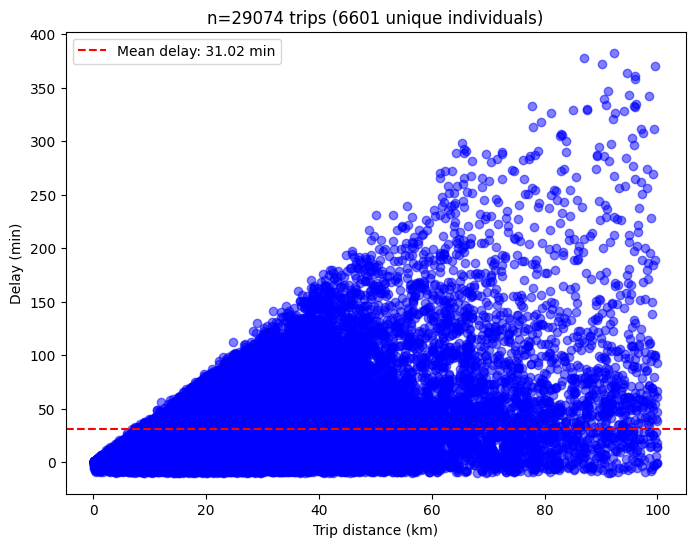

In [23]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_compare['cuebiq_trip_km'], df_compare['diff_time'], color='b', alpha=0.5)
mean_diff_time = df_compare['diff_time'].mean()
plt.axhline(y=mean_diff_time, color='r', linestyle='--', label=f'Mean delay: {mean_diff_time:.2f} min')

# Add labels and title
plt.xlabel('Trip distance (km)')
plt.ylabel('Delay (min)')
plt.title(f'n={df_compare.shape[0]} trips ({df_compare.cuebiq_id.unique().shape[0]} unique individuals)')
plt.legend()
plt.show()

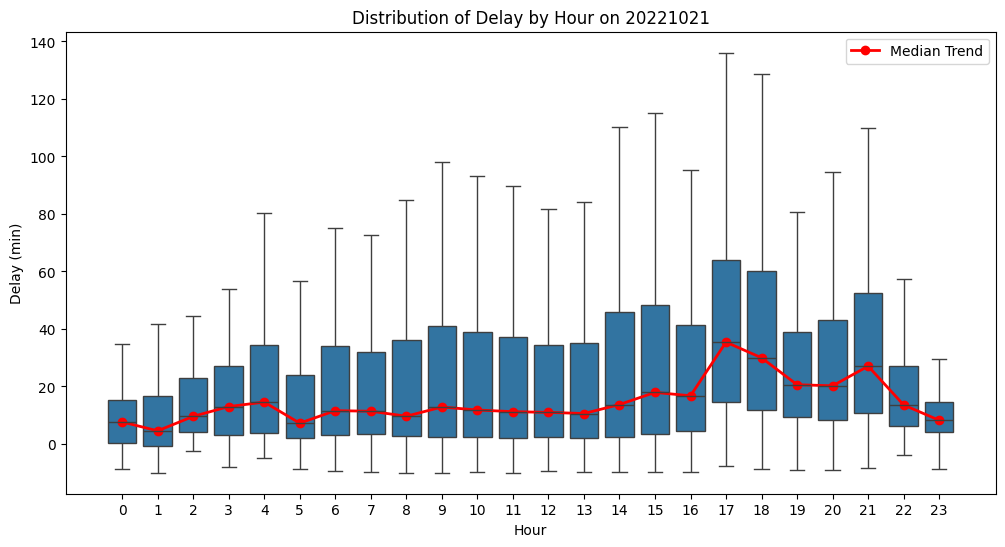

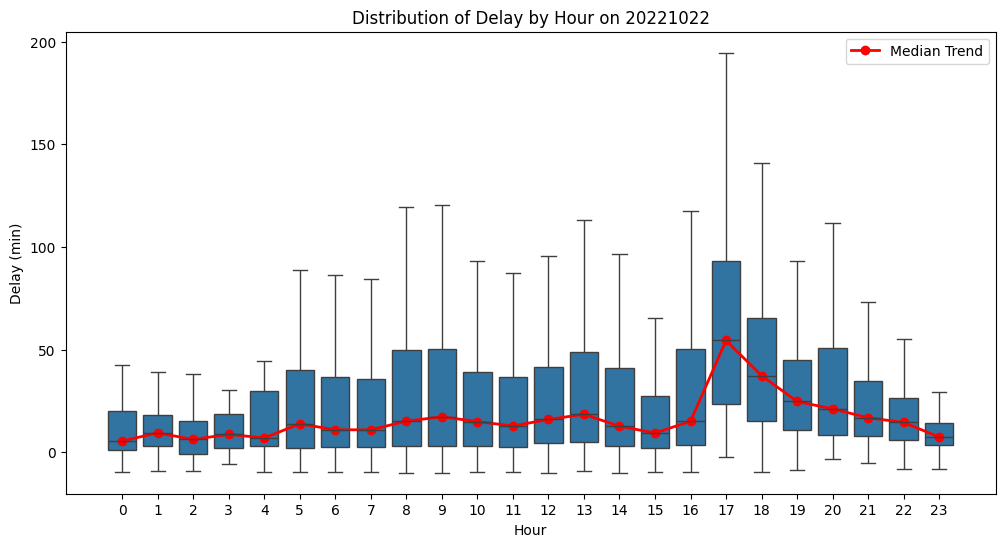

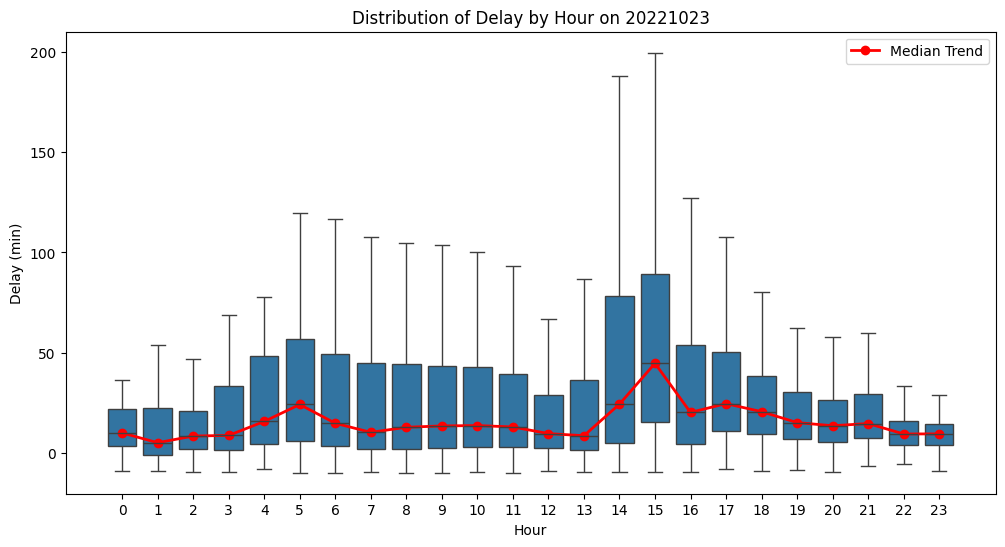

In [26]:
import seaborn as sns

def plot_delay_by_hour(df, date):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='hour', y='diff_time', data=df[df['event_date'] == date], showfliers=False)
    
    # Compute median values for each hour
    hourly_medians = df[df['event_date'] == date].groupby('hour')['diff_time'].median()
    
    # Overlay a line connecting the medians
    plt.plot(hourly_medians.index, hourly_medians.values, color='red', marker='o', linestyle='-', linewidth=2, markersize=6, label='Median Trend')
    plt.xlabel('Hour')
    plt.ylabel('Delay (min)')
    plt.title(f'Distribution of Delay by Hour on {str(date)}')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.show()

plot_delay_by_hour(df_compare, 20221021)
plot_delay_by_hour(df_compare, 20221022)
plot_delay_by_hour(df_compare, 20221023)